#### Data Cleaning

- Only use 8 classes
- vgg16 has its own preprocessing steps

In [9]:
from __future__ import print_function, division
from builtins import range, input

from keras.layers import Input,Lambda,Dense,Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from glob import glob



#### Configuration

- glob 可用於抓路徑放到list

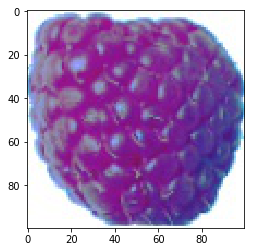

In [10]:
IMAGE_SIZE = [100,100]
epochs = 5
batch_size = 32

# https://www.kaggle.com/paultimothymooney/blood-cells
# train_path = '../large_files/blood_cell_images/TRAIN'
# valid_path = '../large_files/blood_cell_images/TEST'

# https://www.kaggle.com/moltean/fruits
# train_path = '../large_files/fruits-360/Training'
# valid_path = '../large_files/fruits-360/Validation'
train_path = 'data/fruits-360-small/Training'
valid_path = 'data/fruits-360-small/Validation'


# useful for getting number of files
image_files = glob(train_path+'/*/*.jp*g')
valid_image_files = glob(valid_path+'/*/*.jp*g')

# useful for getting number of classes
folders = glob(train_path+'/*')

# look at an image for fun
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

#### VGG16 Model


In [31]:
# add preprocessing layer to the front of VGG

## 3 代表RGB
## include_top >> dense layer
vgg = VGG16(input_shape = IMAGE_SIZE+[3],weights = 'imagenet', include_top = False)


# don't train existing weights

for layer in vgg.layers:
    layer.trainable = False
    
# our layers - you can add more if you want

x = Flatten()(vgg.output)

prediction = Dense(len(folders), activation = 'softmax')(x)

# create a model object

model = Model(inputs = vgg.input,outputs = prediction)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

#### Data Augmentation

- use VGG16 preprocessing input

Found 1289 images belonging to 8 classes.
{'Lemon': 4, 'Kiwi': 3, 'Mango': 5, 'Banana': 2, 'Strawberry': 7, 'Apple Golden 1': 0, 'Avocado': 1, 'Raspberry': 6}
min: -105.68 max: 151.061


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


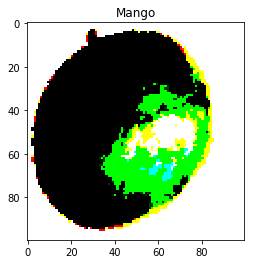

In [32]:
# tell the model what cost and optimization method to use

model.compile(loss = 'categorical_crossentropy',
             optimizer = 'rmsprop',
             metrics = ['accuracy'])

# create an instance of ImageDataGenerator

gen = ImageDataGenerator(rotation_range = 20,
                        width_shift_range = 0.1,
                        height_shift_range =0.1,
                        shear_range = 0.1,
                        zoom_range = 0.2,
                        horizontal_flip = True,
                        vertical_flip = True,
                        preprocessing_function = preprocess_input)


# test generator to see how it works and some other useful things

# get label mapping for confusion matrix plot later

test_gen = gen.flow_from_directory(valid_path,target_size = IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None]*len(test_gen.class_indices)
for k,v in test_gen.class_indices.items():
    labels[v] = k
    

# should be a strangely colored image (due to VGG weights being BGR)
## x= pixel, y = label
for x,y in test_gen:
    print("min:",x[0].min(),"max:",x[0].max())
    plt.title(labels[np.argmax(y[0])])
    plt.imshow(x[0])
    plt.show()
    break
    

#### Train the model

In [33]:
train_generator = gen.flow_from_directory(
    train_path,
    target_size = IMAGE_SIZE,
    shuffle = True,
    batch_size = batch_size)

valid_generator = gen.flow_from_directory(
    valid_path,
    target_size = IMAGE_SIZE,
    shuffle = True,
    batch_size = batch_size)

r = model.fit_generator(
    train_generator,
    validation_data = valid_generator,
    epochs = epochs,
    steps_per_epoch = len(image_files) // batch_size,
    validation_steps = len(valid_image_files)//batch_size)



        


Found 3839 images belonging to 8 classes.
Found 1289 images belonging to 8 classes.
Epoch 1/5
120/119 [==============================] - 25s 212ms/step - loss: 6.1973 - acc: 0.6114 - val_loss: 6.1213 - val_acc: 0.6183
Epoch 2/5
120/119 [==============================] - 26s 217ms/step - loss: 6.0789 - acc: 0.6226 - val_loss: 6.0974 - val_acc: 0.6206
Epoch 3/5
120/119 [==============================] - 26s 218ms/step - loss: 6.0903 - acc: 0.6218 - val_loss: 6.0890 - val_acc: 0.6222
Epoch 4/5
120/119 [==============================] - 28s 230ms/step - loss: 6.0671 - acc: 0.6236 - val_loss: 6.0897 - val_acc: 0.6222
Epoch 5/5
120/119 [==============================] - 27s 225ms/step - loss: 4.1994 - acc: 0.7376 - val_loss: 4.1368 - val_acc: 0.7424


In [37]:
def get_confusion_matrix(data_path,N):
  # we need to see the data in the same order
  # for both predictions and targets
    print("Generating confusion matrix",N)
    predictions = []
    targets = []
    i = 0
    for x, y in gen.flow_from_directory(data_path, target_size = IMAGE_SIZE,shuffle = False,batch_size = batch_size*2):
        i +=1
        if i % 50 == 0:
            print(i)
        p = model.predict(x)
        p = np.argmax(p,axis = 1)
        y = np.argmax(y,axis = 1)
        predictions = np.concatenate((predictions,p))
        targets = np.concatenate((targets,y))
        
        if len(targets) >=N:
            break

    cm = confusion_matrix(targets,predictions)
    return cm

cm = get_confusion_matrix(train_path,len(image_files))
print(cm)
valid_cm = get_confusion_matrix(valid_path,len(valid_image_files))
print(valid_cm)


Generating confusion matrix 3839
Found 3839 images belonging to 8 classes.
50
[[492   0   0   0   0   0   0   0]
 [  0 427   0   0   0   0   0   0]
 [  0   0 490   0   0   0   0   0]
 [  3   0   0 463   0   0   0   0]
 [431  10  40  11   0   0   0   0]
 [  9 481   0   0   0   0   0   0]
 [  0   0   0   0   0   0 490   0]
 [  0   0   0   0   0   0   0 492]]
Generating confusion matrix 1289
Found 1289 images belonging to 8 classes.
[[162   1   1   0   0   0   0   0]
 [  0 143   0   0   0   0   0   0]
 [  0   0 166   0   0   0   0   0]
 [  0   0   0 156   0   0   0   0]
 [142   0  18   4   0   0   0   0]
 [  1 165   0   0   0   0   0   0]
 [  0   0   0   0   0   0 166   0]
 [  0   0   0   0   0   0   0 164]]


#### Plot the data

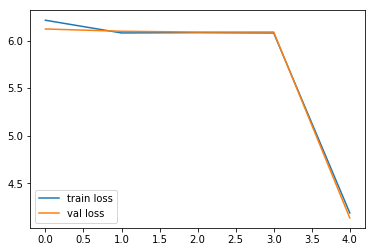

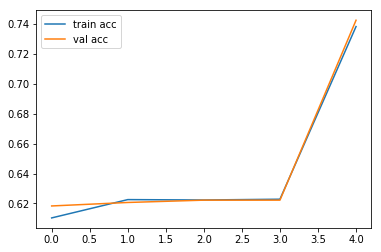

Confusion matrix, without normalization
[[492   0   0   0   0   0   0   0]
 [  0 427   0   0   0   0   0   0]
 [  0   0 490   0   0   0   0   0]
 [  3   0   0 463   0   0   0   0]
 [431  10  40  11   0   0   0   0]
 [  9 481   0   0   0   0   0   0]
 [  0   0   0   0   0   0 490   0]
 [  0   0   0   0   0   0   0 492]]


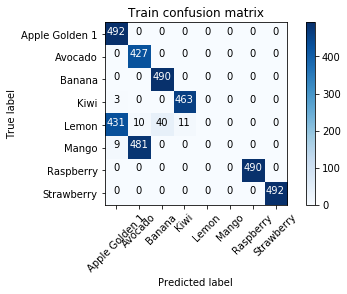

Confusion matrix, without normalization
[[162   1   1   0   0   0   0   0]
 [  0 143   0   0   0   0   0   0]
 [  0   0 166   0   0   0   0   0]
 [  0   0   0 156   0   0   0   0]
 [142   0  18   4   0   0   0   0]
 [  1 165   0   0   0   0   0   0]
 [  0   0   0   0   0   0 166   0]
 [  0   0   0   0   0   0   0 164]]


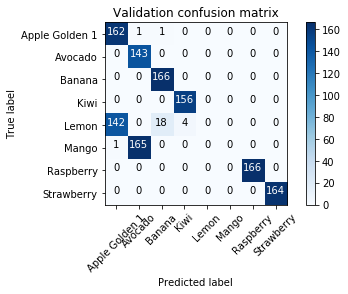

In [46]:
# loss

plt.plot(r.history['loss'],label = 'train loss')
plt.plot(r.history['val_loss'],label = 'val loss')
plt.legend()
plt.show()

# accuracies

plt.plot(r.history['acc'],label = 'train acc')
plt.plot(r.history['val_acc'],label = 'val acc')
plt.legend()
plt.show()

from util import plot_confusion_matrix
plot_confusion_matrix(cm, labels, title='Train confusion matrix')
plot_confusion_matrix(valid_cm, labels, title='Validation confusion matrix')
